In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv('/home/andrey/ds_bootcamp/Phase_0/Week_3/P0_W3_D4_property_project/_data.csv', sep=',', index_col=0)

#Оставляем только Город Москва, все остальные строчки удаляем
df = df[df['Адрес'].str.contains('Москва', case=False, na=False)]

# Извлечение первого числа (этаж)
df['Этаж'] = df['Дом'].apply(lambda x: x.split('/')[0] if pd.notna(x) else None)

# Извлечение второго числа (этажность)
df['Этажность'] = df['Дом'].apply(lambda x: x.split('/')[1].split(',')[0] if pd.notna(x) and '/' in x else None)

# Оставляем только первую часть строки до первого пробела (цифры)
df['Количество комнат'] = df['Количество комнат'].apply(lambda x: x.split(",")[0] if pd.notna(x) else x)

# Преобразуем колонку в числовой тип
df['Количество комнат'] = df['Количество комнат'].astype(float)

# Преобразуем колонку в число
df['Цена'] = df['Цена'].apply(lambda x: x.split(' ')[0])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#Санузел
#  Заполняем колонку "Санузел" на основе ключевых слов в колонке "Описание"
df['Санузел'] = df.apply(lambda row: 'Раздельный' if 'раздельный санузел' in str(row['Описание']).lower()
                         else 'Совмещенный' if 'совмещенный санузел' in str(row['Описание']).lower()
                         else 'Два санузла' if 'два санузла' in str(row['Описание']).lower()
                         else 0, axis=1)

In [4]:
#Можно с детьми/животными
#  Заполняем колонку "Можно с детьми/животными" на основе ключевых слов в колонке "Описание"
df['Можно с детьми/животными'] = df.apply(lambda row: 'Можно с детьми' if 'можно с детьми' in str(row['Описание']).lower()
                                          else 'Можно с животными' if 'можно с животными' in str(row['Описание']).lower()
                                          else 'Нельзя с животными' if 'без животных' in str(row['Описание']).lower()
                                          else 0, axis=1)

In [5]:
# Ремонт
# Заполняем колонку "Ремонт" на основе ключевых слов в колонке "Описание"
df['Ремонт'] = df.apply(lambda row: 'Евроремонт' if 'евроремонт' in str(row['Описание']).lower()
                        else 'Косметический ремонт' if 'косметический ремонт' in str(row['Описание']).lower()
                        else 'Без ремонта' if 'без ремонта' in str(row['Описание']).lower()
                        else 0, axis=1)


In [6]:
#Балкон
df['Балкон'] = df.apply(lambda row: row['Описание'] 
                        if 'балкон' in str(row['Описание']).lower() or 'лоджия' in str(row['Описание']).lower() 
                        else 0, axis=1)

In [7]:
#Окна
df['Окна'] = df.apply(lambda row: row['Описание'] 
                        if 'на улицу' in str(row['Описание']).lower() 
                        or 'во двор' in str(row['Описание']).lower() 
                        or 'на улицу и двор' in str(row['Описание']).lower()
                        else 0, axis=1)

In [8]:
#Метро
#1. Создаем новую колонку, в которой оставляем только части [1] и [2] после разбивки в строке чтоб оставить только улицу и номер дома
df['Краткий Адрес'] = df['Адрес'].apply(lambda x: ', '.join(x.split(',')[1:3]).strip() if len(x.split(',')) > 2 else x)

#2. Создаем словарь, где для каждого "Краткий Адрес" указывается метро (где метро не пустое)
address_metro_mapping = df.dropna(subset=['Метро']).set_index('Краткий Адрес')['Метро'].to_dict()

#3. Заполняем пропуски в колонке "Метро" на основе словаря соответствий
df['Метро'] = df.apply(lambda row: address_metro_mapping.get(row['Краткий Адрес'], row['Метро']), axis=1)

#4. Создаем словарь соответствий ЖК -> Метро (где метро не пустое)
zhk_metro_mapping = df.dropna(subset=['Метро']).set_index('Название ЖК')['Метро'].to_dict()

#5. Заполняем пропуски в колонке "Метро" на основе названия ЖК
df['Метро'] = df.apply(lambda row: zhk_metro_mapping.get(row['Название ЖК'], row['Метро']), axis=1)

# 6. Заполняем оставшиеся пробелы в колонке "Метро" значением 0
df['Метро'] = df['Метро'].fillna(0)

In [9]:
#Название ЖК
# 1. Создаем словарь соответствий Краткий Адрес -> Название ЖК (где название ЖК не пустое)
address_to_zhk_mapping = df.dropna(subset=['Название ЖК']).set_index('Краткий Адрес')['Название ЖК'].to_dict()

# 2. Заполняем пропуски в колонке "Название ЖК" на основе "Краткий Адрес"
df['Название ЖК'] = df.apply(lambda row: address_to_zhk_mapping.get(row['Краткий Адрес'], row['Название ЖК']), axis=1)

df['Название ЖК'] = df['Название ЖК'].fillna(0)

In [10]:
#Лифт
# Заполняем пропуски в колонке "Лифт" значением 1, если в колонке "Название ЖК" не NaN
df['Лифт'] = df.apply(lambda row: "Есть" if pd.notna(row['Название ЖК']) and pd.isna(row['Лифт']) else row['Лифт'], axis=1)

# Создаем словарь соответствий Краткий Адрес -> Лифт (где Лифт не пустое)
address_lift_mapping = df.dropna(subset=['Лифт']).set_index('Краткий Адрес')['Лифт'].to_dict()

# Заполняем пропуски в колонке "Лифт" на основе "Краткий Адрес"
df['Лифт'] = df.apply(lambda row: address_lift_mapping.get(row['Краткий Адрес'], row['Лифт']), axis=1)

# Заполняем колонку "Лифт" значением "Есть", если этажность больше или равна 6
df['Лифт'] = df.apply(lambda row: 'Есть' if pd.notna(row['Этажность']) and int(row['Этажность']) >= 6 else row['Лифт'], axis=1)

# Заполняем колонку "Лифт" значением "Есть", если в колонке "Описание" есть слово "лифт"
df['Лифт'] = df.apply(lambda row: 'Есть' if 'лифт' in str(row['Описание']).lower() else row['Лифт'], axis=1)

df['Лифт'] = df['Лифт'].fillna(0)


In [11]:
#Мусоропровод
# 1. Заполняем пропуски в колонке "Мусоропровод" значением "Есть", если в колонке "Название ЖК" не NaN
df['Мусоропровод'] = df.apply(lambda row: "Есть" if pd.notna(row['Название ЖК']) and pd.isna(row['Мусоропровод']) else row['Мусоропровод'], axis=1)

# 2. Создаем словарь соответствий Краткий Адрес -> Мусоропровод (где Мусоропровод не пустое)
address_trash_mapping = df.dropna(subset=['Мусоропровод']).set_index('Краткий Адрес')['Мусоропровод'].to_dict()

# Заполняем пропуски в колонке "Мусоропровод" на основе "Краткий Адрес"
df['Мусоропровод'] = df.apply(lambda row: address_trash_mapping.get(row['Краткий Адрес'], row['Мусоропровод']), axis=1)

# 3. Заполняем колонку "Мусоропровод" значением "Есть", если в колонке "Описание" есть слово "мусоропровод"
df['Мусоропровод'] = df.apply(lambda row: 'Есть' if 'мусоропровод' in str(row['Описание']).lower() else row['Мусоропровод'], axis=1)

df['Мусоропровод'] = df['Мусоропровод'].fillna(0)


In [12]:
#Парковка
# 1. Заполняем пропуски в колонке "Парковка" значением "Есть", если в колонке "Название ЖК" не NaN
df['Парковка'] = df.apply(lambda row: "Есть" if pd.notna(row['Название ЖК']) and pd.isna(row['Парковка']) else row['Парковка'], axis=1)

# 2. Создаем словарь соответствий Краткий Адрес -> Парковка (где Парковка не пустое)
address_parking_mapping = df.dropna(subset=['Парковка']).set_index('Краткий Адрес')['Парковка'].to_dict()

# Заполняем пропуски в колонке "Парковка" на основе "Краткий Адрес"
df['Парковка'] = df.apply(lambda row: address_parking_mapping.get(row['Краткий Адрес'], row['Парковка']), axis=1)

# 3. Заполняем колонку "Парковка" значением "Есть", если в колонке "Описание" есть слово "парковка"
df['Парковка'] = df.apply(lambda row: 'Есть' if 'парковка' in str(row['Описание']).lower() else row['Парковка'], axis=1)

df['Парковка'] = df['Парковка'].fillna(0)

In [13]:
#Количество комнат
# Разделяем колонку "Площадь, м2" по символу "/"
df[['Общая площадь', 'Жилая площадь', 'Площадь кухни']] = df['Площадь, м2'].str.split('/', expand=True)

# Преобразуем новые колонки в числовой тип (если это нужно)
df[['Общая площадь', 'Жилая площадь', 'Площадь кухни']] = df[['Общая площадь', 'Жилая площадь', 'Площадь кухни']].astype(float)

# Заполняем пропуски в колонке "Жилая площадь" значением, равным половине "Общей площади"
df['Жилая площадь'] = df['Жилая площадь'].fillna(df['Общая площадь'] / 2)

# Шаг 1: Находим медианную (или среднюю) Жилую площадь для каждой группы по количеству комнат
median_living_area = df.groupby('Количество комнат')['Жилая площадь'].median()

# Шаг 2: Функция для заполнения пропусков на основе Жилой площади
def fill_room_count(row, median_living_area):
    if pd.isna(row['Количество комнат']):
        for rooms, median_area in median_living_area.items():
            if row['Жилая площадь'] <= median_area:
                return rooms
        return median_living_area.idxmax()  # Если площадь больше всех медианных значений, возвращаем максимальное количество комнат
    return row['Количество комнат']

# Применяем функцию для заполнения пропусков
df['Количество комнат'] = df.apply(lambda row: fill_room_count(row, median_living_area), axis=1)

df['Количество комнат'] = df['Количество комнат'].fillna(0)

In [14]:
#Площадь комнат, м2
# Проверяем, что в колонках "Жилая площадь" и "Количество комнат" нет пропусков
df['Площадь комнат, м2'] = df['Площадь комнат, м2'].fillna(df['Жилая площадь'] / df['Количество комнат'])

df['Площадь комнат, м2'] = df['Площадь комнат, м2'].fillna(0)

In [15]:
#Высота потолков
# 1: Исключаем строки, где "Высота потолков, м" NaN, чтобы избежать предупреждений
df_non_nan = df.dropna(subset=['Высота потолков, м'])

# 2: Найти медианные значения высоты потолков для каждого ЖК (без NaN значений)
median_ceiling_by_jk = df_non_nan.groupby('Название ЖК')['Высота потолков, м'].transform('median')

# 3: Заполняем пропуски в колонке "Высота потолков, м" медианными значениями для каждого ЖК
df['Высота потолков, м'] = df['Высота потолков, м'].fillna(median_ceiling_by_jk)

# 1: Создаем словарь соответствий 'Краткий Адрес' -> 'Высота потолков, м' (где значение не NaN)
address_ceiling_mapping = df.dropna(subset=['Высота потолков, м']).set_index('Краткий Адрес')['Высота потолков, м'].to_dict()

# 2: Функция для заполнения NaN значений в колонке 'Высота потолков, м' на основе 'Краткий Адрес'
df['Высота потолков, м'] = df.apply(lambda row: address_ceiling_mapping.get(row['Краткий Адрес'], row['Высота потолков, м']) if pd.isna(row['Высота потолков, м']) else row['Высота потолков, м'], axis=1)

# 1: Вычисляем медиану для колонки "Высота потолков, м"
median_ceiling = df['Высота потолков, м'].median()

# 2: Заполняем оставшиеся NaN медианным значением
df['Высота потолков, м'] = df['Высота потолков, м'].fillna(median_ceiling)

In [16]:
#Площадь кухни
#  Шаг 1: Вычисляем медиану для колонки "Площадь кухни"
median_kitchen_area = df['Площадь кухни'].median()

# Шаг 2: Заполняем пропуски в колонке "Площадь кухни" медианным значением
df['Площадь кухни'] = df['Площадь кухни'].fillna(median_kitchen_area)

In [17]:
#Серия дома и Дополнительно
df['Дополнительно'] = df['Дополнительно'].fillna(0)
df['Серия дома'] = df['Серия дома'].fillna(0)

In [18]:
#Переименование колонок
columntranslation = {
    'ID  объявления': 'ID',    
    'Количество комнат': 'Number_of_Rooms',
    'Тип': 'Type',
    'Метро': 'Metro',
    'Адрес': 'Address',
    'Площадь, м2': 'Area_m2',
    'Дом': 'House',
    'Парковка': 'Parking',
    'Цена': 'Price',
    'Телефоны': 'Phones',
    'Описание': 'Description',
    'Ремонт': 'Renovation',
    'Площадь комнат, м2': 'Room_Area_m2',
    'Балкон': 'Balcony',
    'Окна': 'Windows',
    'Санузел': 'Bathroom',
    'Можно с детьми/животными': 'Pets/Children_Allowed',
    'Дополнительно': 'Additional_Info',
    'Название ЖК': 'Housing_Complex',
    'Серия дома': 'House_Series',
    'Высота потолков, м': 'Ceiling_Height_m',
    'Лифт': 'Elevator',
    'Мусоропровод': 'Garbage_Chute',
    'Ссылка на объявление': 'Ad_Link',
    'Этаж': 'Floor',
    'Этажность': 'Total_Floors',
    'Краткий Адрес': 'Short_Address',
    'Цена числовая': 'Price_Numeric',
    'Количество комнат числовое': 'Rooms_Numeric',
    'Жилая площадь, м2': 'Living_Area_m2',
    'Общая площадь': 'Total_area',
    'Жилая площадь': 'Living_area',
    'Площадь кухни': 'Kitchen_area'
}

df.rename(columns=columntranslation, inplace=True)

# Релиз 2 выше

In [19]:
#Сохранение фаил data.csv
df.to_csv('data.csv', index=False)

# Релиз 3

In [20]:
df_data = pd.read_csv('/home/andrey/ds_bootcamp/Phase_0/Week_3/P0_W3_D4_property_project/EDA/EDA_final/data.csv', sep=',')
df.tail(5)

,ID,Number_of_Rooms,Type,Metro,Address,Area_m2,House,Parking,Price,Phones,Description,Renovation,Room_Area_m2,Balcony,Windows,Bathroom,Pets/Children_Allowed,Additional_Info,Housing_Complex,House_Series,Ceiling_Height_m,Elevator,Garbage_Chute,Ad_Link,Floor,Total_Floors,Short_Address,Total_area,Living_area,Kitchen_area
23363,215565511,1.0,Квартира,м. Говорово (8 мин пешком),"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",35.0/16.4/8.0,10/14,Есть,42000.0,+79154383401,Сдаётся светлая теплая квартира (студия) с бал...,0,16.4,Сдаётся светлая теплая квартира (студия) с бал...,0,0,0,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",Мещерский лес,0,2.70,Есть,Есть,https://www.cian.ru/rent/flat/215565511,10,14,"Боровское шоссе, 2к7",35.0,16.40,8.0
23364,274654844,1.0,Квартира,м. Солнцево (7 мин пешком),"Москва, Производственная улица, 8к1, ш. Боровс...",38.7/16.5/11.0,"5/18, Монолитный",Есть,45000.0,+79151173402,Сдам однокомнатную квартиру на длительный срок...,0,16.5,0,0,0,0,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",Лучи,0,2.75,Есть,Есть,https://www.cian.ru/rent/flat/274654844,5,18,"Производственная улица, 8к1",38.7,16.50,11.0
23365,268679909,2.0,Квартира,м. Говорово (10 мин пешком),"Москва, Боровский проезд, 11",43.1,"5/5, Кирпичный",Есть,50000.0,+79653825192,Рассматриваются квартиранты только славяне и т...,0,10.775,Рассматриваются квартиранты только славяне и т...,0,0,Нельзя с животными,"Мебель на кухне, Душевая кабина, Стиральная ма...",0,0,2.50,Есть,Есть,https://www.cian.ru/rent/flat/268679909,5,5,"Боровский проезд, 11",43.1,21.55,9.0
23366,274807525,2.0,Квартира,м. Говорово (10 мин пешком),"Москва, улица Богданова, 6к1, ш. Боровское (3 ...",52.5/10.0,"8/23, Монолитный",наземная,55000.0,+79660611965,Двухкомнатная уютная квартира с видом во внутр...,0,5.0,0,Двухкомнатная уютная квартира с видом во внутр...,0,0,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",0,0,2.65,Есть,Да,https://www.cian.ru/rent/flat/274807525,8,23,"улица Богданова, 6к1",52.5,10.00,9.0
23367,274672243,2.0,Квартира,м. Говорово (10 мин пешком),"Москва, улица Богданова, 2к1, ш. Боровское (3 ...",90.0/48.2/15.5,"6/23, Панельный",Есть,57000.0,+79623641533,Сдается просторная двухкомнатная квартира ВПЕР...,0,"26,2+15,5-22,0",Сдается просторная двухкомнатная квартира ВПЕР...,0,0,0,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",0,0,2.70,Есть,Да,https://www.cian.ru/rent/flat/274672243,6,23,"улица Богданова, 2к1",90.0,48.20,15.5


In [21]:
# Приводим таблицу к int и float
# Список колонок, для которых нужно применить логику
columns_to_modify = ['Type', 'Metro', 'Address', 'Area_m2', 'House', 'Parking', 'Phones', 'Description', 
                     'Renovation', 'Room_Area_m2', 'Balcony', 'Windows', 'Bathroom', 'Pets/Children_Allowed', 
                     'Additional_Info', 'House_Series', 'Elevator', 'Garbage_Chute', 'Ad_Link', 
                     'Total_Floors', 'Short_Address']

# Применяем логику для всех колонок: если значение строковое и не "0", ставим 1, иначе 0
for col in columns_to_modify:
    df_data[col] = df_data[col].apply(lambda x: 1 if isinstance(x, str) and x != '0' else 0)


# Преобразуем колонку 'Housing_Complex': если есть строковое значение, ставим 1, иначе 0
df_data['Housing_Complex'] = df_data['Housing_Complex'].apply(lambda x: 1 if isinstance(x, str) and x != '0' else 0)

df_data['Metro'] = df_data['Housing_Complex'].apply(lambda x: 1 if isinstance(x, str) and x != '0' else 0)





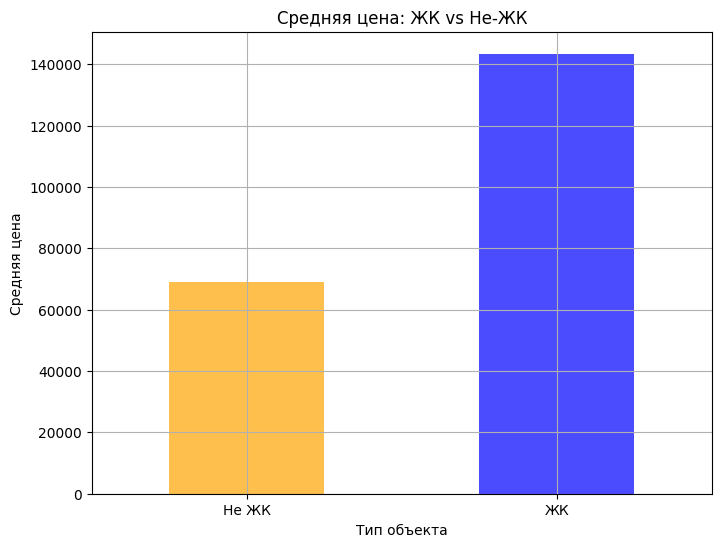

In [22]:
# Разделение данных на объекты в ЖК и не в ЖК
df_data['Housing_Complex'] = df_data['Housing_Complex'].astype(int)

# Группируем данные по колонке "Housing_Complex" и считаем среднюю цену
average_price_by_complex = df_data.groupby('Housing_Complex')['Price'].mean()

# Построение графика
plt.figure(figsize=(8, 6))
ax = average_price_by_complex.plot(kind='bar', color=['orange', 'blue'], alpha=0.7)

# Изменяем метки оси X
ax.set_xticklabels(['Не ЖК', 'ЖК'], rotation=0)

# Добавляем заголовки и сетку
plt.title('Средняя цена: ЖК vs Не-ЖК')
plt.xlabel('Тип объекта')
plt.ylabel('Средняя цена')
plt.grid(True)

# Сохраняем график перед отображением
plt.savefig('average_price_zk_vs_nonzk.png', dpi=300, bbox_inches='tight')  # Сохраняем с высоким разрешением

# Отображаем график
plt.show()


## Из графика видно, что средняя цена объектов недвижимости в ЖК значительно выше, чем объектов не в ЖК.

- Средняя цена объектов, находящихся в ЖК, превышает 140,000, что почти в два раза больше, чем средняя цена объектов не в ЖК, которая составляет около 70,000.
- Этот результат может говорить о том, что объекты в жилых комплексах (ЖК) считаются более престижными и дорогими. Возможно, они предоставляют лучшие условия или находятся в более привлекательных районах.

Таким образом, можно сделать вывод, что наличие объекта в ЖК может быть значительным фактором, влияющим на его рыночную стоимость.

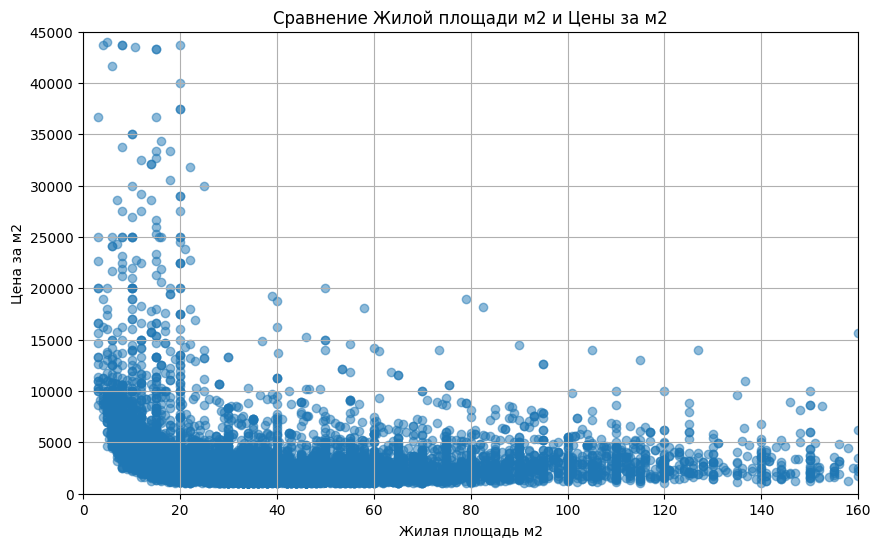

In [23]:
# Создаем колонку с ценой за квадратный метр (Price_per_m2)
df_data['Price_per_m2'] = df_data['Price'] / df_data['Living_area']

# Устанавливаем порог для удаления выбросов
upper_limit = 45000

# Удаляем выбросы
df_filtered = df_data[df_data['Price_per_m2'] < upper_limit]

# Убираем нулевые или маленькие значения цены за квадратный метр
df_filtered = df_filtered[df_filtered['Price_per_m2'] > 1000]

# Ограничиваем значения жилой площади до 160 m2
df_filtered = df_filtered[df_filtered['Living_area'] <= 160]

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Living_area'], df_filtered['Price_per_m2'], alpha=0.5)
plt.xlim(0, 160)
plt.ylim(0, 45000)
plt.title('Сравнение Жилой площади м2 и Цены за м2')
plt.xlabel('Жилая площадь м2')
plt.ylabel('Цена за м2')
plt.grid(True)

# Сохраняем график
plt.savefig('living_area_vs_price_per_m2.png', dpi=300, bbox_inches='tight')  # Сохраняем с высоким разрешением

# Отображаем график
plt.show()


### На графике видно, что:

- Цена за квадратный метр имеет тенденцию снижаться с увеличением жилой площади. На маленьких квартирах (до 20 м²) цена за квадратный метр намного выше, чем на более просторных квартирах.

- Диапазон цен для небольших квартир (менее 20 м²) варьируется значительно, достигая до 45,000 рублей за квадратный метр. Однако для более крупных квартир (свыше 50 м²) цены за квадратный метр становятся более стабильными и находятся в пределах 5,000 - 10,000 рублей.

- Выбросы присутствуют в виде высоких значений на маленьких площадях, что может быть связано с более дорогими объектами, расположенными в престижных районах или новыми постройками.

В общем, чем больше площадь квартиры, тем меньше цена за квадратный метр, что является стандартной закономерностью на рынке недвижимости.

In [24]:
#Сохранение фаил data.csv
df_data.to_csv('data_final.csv', index=False)